In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, mean_squared_error

In [ ]:
# Define image dimensions for preprocessing.
height = 300
width = 300

In [ ]:
# Define directories for training and validation data.
train_dir = "/content/drive/MyDrive/Dataset Of 100 /Training"
validation_dir = "/content/drive/MyDrive/Dataset Of 100 /Validation"
test_dir = "/content/drive/MyDrive/Dataset Of 100 /Testing"

In [ ]:
# Number of batches for data generators.
batch_size = 8

In [ ]:
# Data augmentation for training images.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                   horizontal_flip=True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(height, width),
                                                    batch_size=batch_size, class_mode='binary')


Found 243 images belonging to 2 classes.


In [ ]:
# Data augmentation for validation images.
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                        horizontal_flip=True, vertical_flip=True)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(height, width),
                                                              batch_size=batch_size, class_mode='binary')


Found 183 images belonging to 2 classes.


In [ ]:
# Data augmentation for test images.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=90,
                                  horizontal_flip=True, vertical_flip=True)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(height, width),
                                                  batch_size=batch_size, class_mode='binary')

Found 4 images belonging to 2 classes.


In [ ]:
# Load ResNet50 model without top layer.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Add custom top layers for classification.
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
# Combine base model with custom top layers.
finetune_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze layers of the base model.
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model.
finetune_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


In [ ]:
# Checkpoint and early stopping.
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)


In [ ]:
# Train the model on training data with validation on validation data.
history = finetune_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100,
                             validation_data=validation_generator, validation_steps=len(validation_generator),
                             callbacks=[checkpoint, early_stop])

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 25.6103 - accuracy: 0.8683
Epoch 1: val_accuracy improved from -inf to 0.95628, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 327s 11s/step - loss: 25.6103 - accuracy: 0.8683 - val_loss: 3.1155 - val_accuracy: 0.9563
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 7.4762 - accuracy: 0.9342
Epoch 2: val_accuracy improved from 0.95628 to 1.00000, saving model to best_model.h5
31/31 [==============================] - 310s 10s/step - loss: 7.4762 - accuracy: 0.9342 - val_loss: 1.2323e-13 - val_accuracy: 1.0000
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.9877
Epoch 3: val_accuracy did not improve from 1.00000
31/31 [==============================] - 295s 10s/step - loss: 0.6234 - accuracy: 0.9877 - val_loss: 0.3416 - val_accuracy: 0.9891
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 3.8257 - accuracy: 0.9588
Epoch 4: val_accuracy did not improve from 1.00000
31/31 [==============================] - 297s 10s/step - loss: 3.8257 - accuracy: 0.9588 - val_loss: 0.6405 - val_accuracy: 0.994

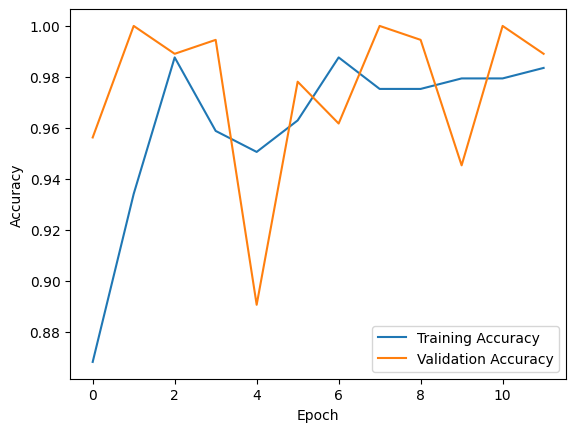

In [ ]:
# Plot training and validation accuracy over epochs.
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


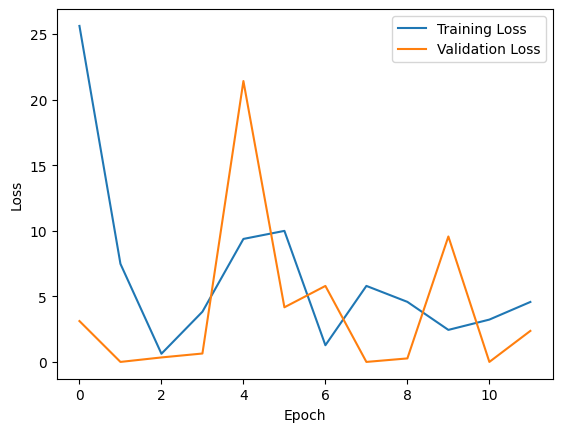

In [ ]:
# Plot training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Testing the model.
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"

1/1 [==============================] - 5s 5s/step


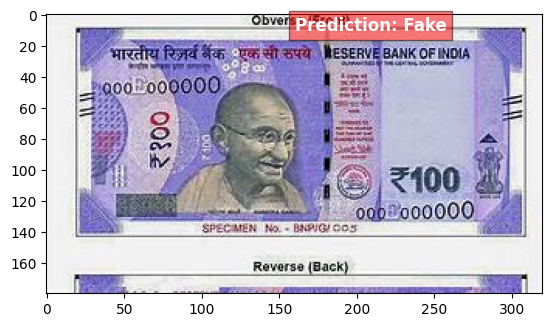

Prediction: Fake


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/Dataset Of 100 /Testing/Fake/F 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 1s 622ms/step


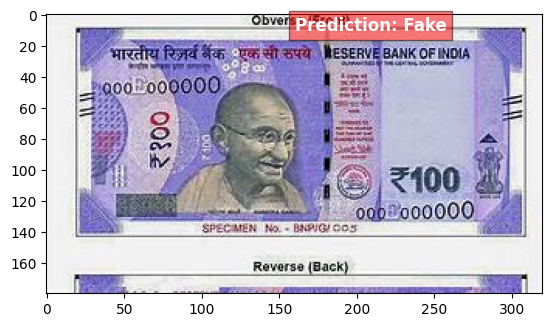

Prediction: Fake


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/Dataset Of 100 /Testing/Fake/F 2.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)


1/1 [==============================] - 1s 749ms/step


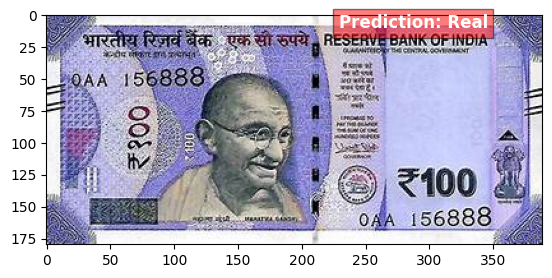

Prediction: Real


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/Dataset Of 100 /Testing/Real/ R 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)

1/1 [==============================] - 1s 674ms/step


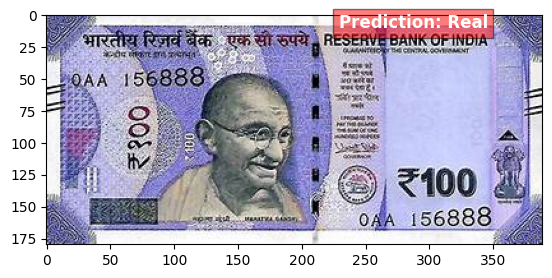

Prediction: Real


In [ ]:
# Specify the image path
test_img_path = "/content/drive/MyDrive/Dataset Of 100 /Testing/Real/ R 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10,f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console if needed
print("Prediction:", prediction)

In [ ]:
# Calculate overall accuracy of the model on the validation set.
overall_accuracy = finetune_model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)
# Print overall accuracy.
print("Validation Accuracy:", overall_accuracy[1])

<ipython-input-27-0361a3b2b6e7>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  overall_accuracy = finetune_model.evaluate_generator(generator=validation_generator, steps=len(validation_generator), verbose=1)


23/23 [==============================] - 75s 3s/step - loss: 0.0782 - accuracy: 0.9945
Validation Accuracy: 0.994535505771637


In [ ]:
# Calculate overall accuracy of the model on the training set.
overall_accuracy_training = finetune_model.evaluate_generator(generator=train_generator, steps=len(train_generator), verbose=1)
# Print overall accuracy on training set.
print("Overall Accuracy on Training Set:", overall_accuracy_training[1])


<ipython-input-28-46e751aa18a4>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  overall_accuracy_training = finetune_model.evaluate_generator(generator=train_generator, steps=len(train_generator), verbose=1)


31/31 [==============================] - 99s 3s/step - loss: 0.0319 - accuracy: 0.9959
Overall Accuracy on Training Set: 0.9958847761154175


In [ ]:
# Predict the whole validation set
validation_generator_predict.reset()
predictions = finetune_model.predict(validation_generator_predict, steps=len(validation_generator_predict), verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = validation_generator_predict.classes

23/23 [==============================] - 82s 3s/step


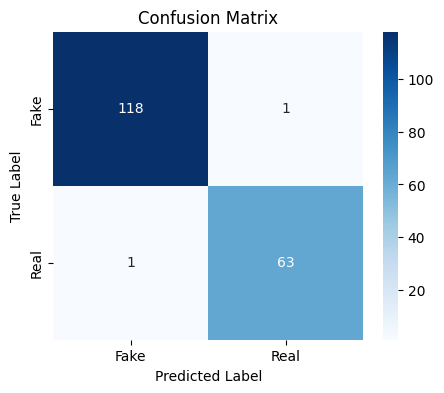

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Mean Squared Error
mse = mean_squared_error(true_classes, predicted_classes)
print(f"Mean Squared Error: {mse*100}")

Mean Squared Error: 1.092896174863388
